# **Bayesian Regression - Closed Form Model**

Using the historical data we find the best lap time set per driver per year.

Model 1 - Bayesian regression on best lap times per driver using 2017/18/19 data, the output posterior of this is the parameters of the model given the data. This output will be the prior for the new model - this can be saved  to a pickle file so it does not have to be re-run before real time updates (note that the closed form model runs fast anyway but this may be useful for the sampling model).

Model 2 - Bayesian regression on incoming lap times per driver sequentially to update the parameters (weights and biases), at each update I calculate the predicted cut-off for 2020 per driver, rank them and take the 16th as the cutoff prediction for Q1 and the 11th for Q2 (this runs in live time and has standard deviation as per requested). Note that for drivers who have no historical data a non-informative prior is used instead of the posterior from model 1. Note that it only updates if a faster lap comes in and therefore will automatically avoid updating on slow laps.

The feature value here is only the value 2020 in both models as there was not enough data to incorporate other features, also there seems to be a strong time dependency.

Bayesian Regression was coded from scratch using the MML (Matematics for Machine Learning) book by Marc Deisenroth, I have tried to use the book notation where I can so that it is clear and labelled where certain book equatins are used.

Make sure to specify if you want Q1 or Q2 in the cell directly below.
Make sure to specify if you want to include historical data (i.e.to run Model 1) - if not Model 2 will take P3 data parameters as the prior.

Note:

This track was not featured in 2020 so we can only run Model 1 with non informative priors to get 2020 predictions

In [1]:
Session = 'Q2' # enter session that we are interested in: 'Q1' or 'Q2'
Historicals = True # enter false if you do not want to run with historical data i.e. bypass model 1 and use practice data as model 2 prior

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import display

import scipy as sp
import itertools

from scipy.stats import norm, multivariate_normal
#from scipy.optimize import minimize

import pickle
import copy

In [3]:
## Optional: Function can save the prior dictionary created as a pickle file, so that Model 1 does not have to be run again ##

def savePickle(prior, name):

    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(prior, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [4]:
## Function will open pickle file ##

def openPickle(name):
  
    filename = name + '.pickle'

    with open(filename, 'rb') as file:
        prior = pickle.load(file)

    return prior

Data Processing

In [5]:
## Read data into a Pandas DataFrame from a CSV file ##

def read_data(filename):
    
    df = pd.read_csv(filename)
    
    # select required columns
    d = df[['Season', 'Time of Day', 'Session', 'Driver Short Name', 'Full Lap', 'Team']].copy()
    
    ''' some sectors have missing values (probably where a car has been taken off, 
    convert the white space to NaN objects and drop them'''
    
    d.replace(' ', np.nan, inplace = True) 
                                              
    data = d.dropna()
    
    return data

In [6]:
## Remove Slow Laps ##

def drop_slow_laps(data):
    
    threshold = np.min(data['Full Lap']) + 3 # would not expect drivers to have best laps > 2 seconds of the min but use 3 for redundancy
    
    clean_data = data[data['Full Lap'] <= threshold]
    
    return clean_data

In [7]:
## Read in all relevant files - excluding sessions where there was rain or a red flag ##

# read data
data_20 = read_data('07_05A1r_Qu_2020.csv') # austria data loaded to get drivers for 2020 only
data_19 = read_data('03_17Mel_Qu_2019.csv')
data_18 = read_data('03_25Mel_Qu_2018.csv')
data_17 = read_data('03_26Mel_Qu_2017.csv')

# split data into Q1 and Q2 per year
data_20_Q1 = drop_slow_laps(data_20[data_20['Session'] == 'Q1'])
data_20_Q2 = drop_slow_laps(data_20[data_20['Session'] == 'Q2'])

data_19_Q1 = drop_slow_laps(data_19[data_19['Session'] == 'Q1'])
data_19_Q2 = drop_slow_laps(data_19[data_19['Session'] == 'Q2'])

data_18_Q1 = drop_slow_laps(data_18[data_18['Session'] == 'Q1'])
data_18_Q2 = drop_slow_laps(data_18[data_18['Session'] == 'Q2'])

data_17_Q1 = drop_slow_laps(data_17[data_17['Session'] == 'Q1'])
data_17_Q2 = drop_slow_laps(data_17[data_17['Session'] == 'Q2'])


# list of all historical dataframes for Q1 and Q2
hist_data_Q1 = [data_19_Q1, data_18_Q1, data_17_Q1]
hist_data_Q2 = [data_19_Q2, data_18_Q2, data_17_Q2]

In [8]:
## Names of drivers that made it into each qualifying session ##

names_2020_Q1 = np.unique(data_20_Q1['Driver Short Name']) # finds the drivers that raced in 2020 Q1
assert len(names_2020_Q1) == 20

names_2020_Q2 = np.unique(data_20_Q2['Driver Short Name']) # finds the drivers that raced in 2020 Q1
assert len(names_2020_Q2) == 15

In [9]:
## Fastest lap time per driver ##

def best_lap(data, name): # driver name is a string i.e 'HAM'
    
    if np.sum(data['Driver Short Name'] == name) > 0: # if there is data for the driver
    
        df = data[data['Driver Short Name'] == name]
        min_idx = np.where(df['Full Lap'] == np.min(df['Full Lap']))[0]
        fastest = df.iloc[min_idx, :]

        return fastest

    else: # if there is not data for the driver
        
        return [0, 0, 0, 0, 0] # list of 5 - bigger than it can possibly be so shows where there is missing data, 
                               # can use this to filter it out later

In [10]:
## Store hisotircal best lap for all drivers for Q1 and Q2 ##

lap_dict_Q1 = {}

for name in names_2020_Q1:
    laps = pd.DataFrame()

    for data in hist_data_Q1:
        lap = best_lap(data, name)

        if len(lap) < 5: # for drivers without historical data, fills in blank lap
            laps = laps.append(lap)

    lap_dict_Q1[name] = laps


    
lap_dict_Q2 = {}

for name in names_2020_Q2:
    laps = pd.DataFrame()
    
    for data in hist_data_Q2:
        lap = best_lap(data, name)

        if len(lap) < 5:
            laps = laps.append(lap)
        
    lap_dict_Q2[name] = laps

In [11]:
lap_dict_Q1['LEC']

,Season,Time of Day,Session,Driver Short Name,Full Lap,Team
15,2019,17:18:53.4700000,Q1,LEC,81.893,Ferrari
77,2018,17:18:48.3520000,Q1,LEC,84.518,Sauber


In [12]:
lap_dict_Q2['LEC']

,Season,Time of Day,Session,Driver Short Name,Full Lap,Team
64,2019,17:29:05.0410000,Q2,LEC,81.615,Ferrari


Model Components

In [13]:
## Model 1 to get the posterior on parameters given historical data = prior for model 2 ##

def fitBR(inputs, observed, initial_params = None):
    
    if initial_params != None:
        initial_slope, initial_sigma, initial_intercept = initial_params # initial params is a list of tuples (mean, sd)
  
    else: # set non-informative priors for the parameters that have no historical data - this will not ever be called unless we are not going to use P3 priors (kept for redundancy)
        initial_slope = (0, 1) 
        initial_intercept = (0, 1)
        initial_sigma = 1 # non informative sigma term for likelihood term (eq 9.35 MML)
    
    prior_m_w = initial_slope[0] # prior weights/slope
    prior_m_b = initial_intercept[0] # prior biases/intercept
    
    prior_s_w = initial_slope[1] # prior weights/slope sd
    prior_s_b = initial_intercept[1] # prior biases/intercept sd
    
    m_0 = np.hstack([prior_m_w, prior_m_b]).reshape(-1, 1) # prior mean

    S_0 = np.diag([prior_s_w**2, prior_s_b**2]) # prior covariance matrix - set it to a diagonal matrix so that the variables are independent i.e weights and biases have no covariance

    S_0_inv = np.linalg.inv(S_0) # prior covariance matrix inverse

    sigma_squared = initial_sigma ** 2 # likelihood variance

    phi = np.vstack([inputs, np.ones(len(inputs))]).T # features matrix NxD by MML convention
    y = observed.reshape(-1, 1).astype('float64') # labels vector Nx1 by MML convention

    S_N = np.linalg.inv(S_0_inv + (1/sigma_squared) * (phi.T @ phi)) # posterior covariance (eq 9.43b MML)
    m_N = S_N @ (S_0_inv @ m_0 + (1/sigma_squared) * (phi.T @ y)) # posterior mean (eq 9.43c MML)
    
    return m_N, S_N

In [14]:
## Predicts a series of gaussians for each input point, it returns the mean and sd of each prediction (eq 9.57c MML) ##

def pred(inputs, mu_post, cov_post, sigma_lik):
    
    '''
    Dimensions of inputs (MML book convention): 
    
    inputs: N
    mu_post: Dx1 (posterior mean)
    cov_post: DxD (posterior covariance)
    sigma_lik: scalar
    '''
    phi = np.vstack([inputs, np.ones(len(inputs))]).T
    
    mu = phi @ mu_post.reshape(-1, 1) # Nx1
    var = phi @ cov_post @ phi.T + (sigma_lik ** 2) # Nx1 - variance not covariance
    sd = np.sqrt(np.abs(var))
    
    return mu, sd

In [15]:
## Model 2 to update the posterior as new data gets fed in ##

def updateBR(inputs, observed, initial_params): # initial params should be a list of [m0, S_0, sigma]
    
    m_0 = initial_params[0]
    S_0 = initial_params[1]
    S_0_inv = np.linalg.inv(S_0)
    
    sigma_squared = initial_params[2] ** 2

    phi = np.vstack([inputs, np.ones(len(inputs))]).T # features matrix NxD 
    y = observed.reshape(-1, 1).astype('float64') # labels vector Nx1

    S_N = np.linalg.inv(S_0_inv + (1/sigma_squared) * (phi.T @ phi))  # posterior covariance 
    m_N = S_N @ (S_0_inv @ m_0 + (1/sigma_squared) * (phi.T @ y))  # posterior mean
    
    return m_N, S_N

In [16]:
## Closed form update for sigma likelihood term (eq 9.22 MML (maximum likelihood estimate of the noise variance)) ##

def fit_sigma_lik(init, inputs, observed, prior_mean, prior_cov):
    
    if len(inputs) > 1: # if there is enough historical data for drivers (requires 2 points)
        phi = np.vstack([inputs, np.ones(len(inputs))]).T
        preds = phi @ prior_mean
        sigma_sq = np.mean((observed - preds.reshape(-1))**2)
        sigma = np.sqrt(sigma_sq)
        
        return sigma
    
    else:
        return init

Model 1

In [17]:
## Find the priors for all drivers using Model 1 and stores them ##

if Session == 'Q1':
    historical_data = lap_dict_Q1 
    names_2020 = names_2020_Q1
    sigma_list = 1 * np.ones(len(names_2020)) # sigma original value for each driver - set arbitrarily to 1 for each driver
    lap = 82
    
elif Session == 'Q2':
    historical_data = lap_dict_Q2
    names_2020 = names_2020_Q2
    sigma_list = 1 * np.ones(len(names_2020))
    lap = 81
    

driver_prior = {}
 
for idx, driver in enumerate(names_2020):
    
    #print(f'Current Driver: {driver}')
    driver_data = historical_data[driver]
    
    # set prior weight to practice session and prior bias is non-informative
    
    prior_m_w = lap/2020 # estimate 
    prior_s_w = (lap * 0.02)/2020 # estimate
    
    prior_m_b = 0
    prior_s_b = 1
    
    m_0 = np.hstack([prior_m_w, prior_m_b]).reshape(-1, 1) # prior mean

    S_0 = np.diag([prior_s_w**2, prior_s_b**2]) # prior covariance matrix
    
    if Historicals == True: # if we want to include historical data

        if len(driver_data) > 0: # if there is historical data for the driver

            driver_data = driver_data.loc[:, ['Season', 'Full Lap']]
            inputs = np.array(driver_data['Season'].astype('float64')) # features - the season (2020 in this case)
            observed = np.array(driver_data['Full Lap']) # labels - full lap time (best lap per year from pre-processing above)

            sigma_lik = sigma_list[idx] # likelihood sigma term starting point (non-infomative)
            driver_posterior = fitBR(inputs, observed, [(prior_m_w, prior_s_w), sigma_lik, (prior_m_b, prior_s_b)]) # fit to historicals using Model 1

            new_sigma_lik = fit_sigma_lik(sigma_lik, inputs, observed, driver_posterior[0], driver_posterior[1]) # update the likelihood sigma term
            driver_prior[driver] = [driver_posterior[0], driver_posterior[1], sigma_lik, new_sigma_lik] # update prior dictionary

        else: # if there is no historical data for the driver then keep prior as practice session weight and estimated bias
            sigma_lik = sigma_list[idx]
            driver_prior[driver] = [m_0, S_0, sigma_lik, sigma_lik]
    
    else:
        sigma_lik = sigma_list[idx]
        driver_prior[driver] = [m_0, S_0, sigma_lik, sigma_lik] # note that without historical data we cannot use MLE to find sigma in likelihood

In [18]:
## Store driver names as an index and keep dictionary both ways to later identify drivers ##

name_to_idx = {} 
idx_to_name = {}

idx = 0

for name in names_2020:
    name_to_idx[name] = idx
    idx_to_name[idx] = name
    idx += 1

In [19]:
## Initialize everything ##

current_predictions = []
current_predictions_sd = []
current_predictions_conservative = [] # will store mean - sd for each driver

inputs = [2020]

for name in names_2020:
    
    if len(driver_prior[name]) > 0:
        
        mean_pred, sd_pred = pred(inputs, driver_prior[name][0], driver_prior[name][1], driver_prior[name][2]) # change to 3 for sigma updates
        current_predictions.append(mean_pred.item())
        current_predictions_sd.append(sd_pred.item())
        current_predictions_conservative.append(mean_pred.item() - sd_pred.item())
        
        
    else:
        
        current_predictions.append(np.inf) # set to a very large value if there is no historical data - this is so it can be identified
        current_predictions_sd.append(1) # set sd to 1
        current_predictions_conservative.append(np.inf)

current_fastest = np.array([np.inf] * len(names_2020)) # set current fastest to be something really big so that the first incoming laps can update the model per driver

i = np.argsort(current_predictions)[-5] # 16th position for Q1, 11th position for Q2 - slowest 5 will not make it through in both rounds
j = np.argsort(current_predictions_conservative)[-5]

print(f'Initial mean predictions from historical data are: {current_predictions}')
print(f'Initial standard deviation predictions from historical data are: {current_predictions_sd}')
print(f'Initial predicted cut-off is: {current_predictions[i]:.3f}')
print('')
print(f'Initial conservative predictions from historical data are: {current_predictions_conservative}')
print(f'Initial conservative predicted cut-off is: {current_predictions_conservative[j]:.3f}')

Initial mean predictions from historical data are: [82.21671393009939, 82.0302023759774, 81.0, 83.11717577438559, 81.97489394578955, 83.44062181339275, 81.51354203942935, 82.04974000288345, 84.65568108231606, 83.59430732107948, 82.93406827001684, 83.64607666068629, 83.5029211715841, 82.54604898130836, 82.26239603426147]
Initial standard deviation predictions from historical data are: [1.3357381459658035, 1.1426551043207192, 2.1504418150696383, 1.1426551043207192, 1.1426551043207192, 1.1999748979067362, 1.3357381459658035, 1.3357381459658035, 1.2000328294326656, 1.1426551043207192, 1.1426551043207192, 1.2000328294326656, 1.3359032952735757, 1.1426551043207192, 1.1426551043207192]
Initial predicted cut-off is: 83.441

Initial conservative predictions from historical data are: [80.88097578413358, 80.88754727165667, 78.84955818493036, 81.97452067006486, 80.83223884146882, 82.24064691548601, 80.17780389346355, 80.71400185691765, 83.45564825288339, 82.45165221675876, 81.79141316569611, 82.44

In [20]:
# if any of the drivers did not have prior historical information and initial prediction got set to np.inf then we will replace it with the mean of the other predictions (this is so that the probability function will work))

current_predictions = np.array(current_predictions)
current_predictions_sd = np.array(current_predictions_sd)
mean_of_means = np.mean(current_predictions[current_predictions != np.inf])
mean_of_sd = np.mean(current_predictions_sd[current_predictions_sd != np.inf])

current_predictions[current_predictions == np.inf] = mean_of_means
current_predictions_sd[current_predictions_sd == np.inf] = mean_of_sd

Plot construction

In [21]:
# Plot the posterior predictive dist - this will enable a quick check for individual drivers ##

def norm_curves(mean, sd):

    #cdf = norm.sf(x = target, loc = mean, scale = sd) # sf = survival function returns 1 - cdf

    fig, ax = plt.subplots()
    
    x_axis = np.linspace(mean - 3, mean + 3, 1000)
    ax.plot(x_axis, norm.pdf(x_axis, loc = mean, scale = sd))
    ax.set_title(f'$N \sim ({mean:.3f}, ${sd:.3f}^2$)$')
    ax.set_xlabel('Lap time (s)')
    ax.set_ylabel('pdf(Lap time)')
    ax.grid(True)
    plt.show()

# norm_curves(pred_dictionary['NOR'][0], pred_dictionary['NOR'][1]) # look at individual distribution

In [22]:
## Function creates useful plots - normal curves, boxplots, prediction bar charts and actual laps set/predicted cutoff ##

def plots(predictions, standard_dev, cutoff, names_list, label, stage, data):
    
    plot_time = stage
    save_path = '/Users/chanelbrown/Desktop/Notebooks/Bayesian Regression Models and Data Per Track/Australia-Melbourne-Mel/Plots'
    
   
    plot_type = 'b'
        
    ## Predictive Lap Time Distribution Normal Curves ##
    
    pred_dictionary = {} # store most recent predictions in a dictionary with the driver name as key

    for i in range(len(names_list)):
        pred_dictionary[idx_to_name[i]] = [predictions[i], standard_dev[i]]

    
    # find which team each driver was racing for in the event and return the colour of the team in a dictionary ##
    team_color = {'Mercedes AMG': 'c', 'Alfa Romeo': 'maroon', 'Ferrari': 'r', 'Red Bull': 'b', 'Williams': 'g',
                   'AlphaTauri': 'darkblue', 'Haas': 'pink', 'Racing Point': 'darkmagenta', 'McLaren': 'darkorange', 'Renault': 'gold'}
    
    teams = {}

    for name in names_list:
        teams[name] = np.unique(data[data['Driver Short Name'] == name]['Team']).item()

    driver_color = {} 

    for key, value in teams.items():
        driver_color[key] = team_color[value]

    
    fig, ax = plt.subplots(figsize = (10, 10))

    # find the corresponding team color for the driver and change line style to distinguish between drivers in the same team
    colors = []
    line_dash = []

    for key, value in driver_color.items():

        if value in colors:
            colors.append(value)
            line_dash.append('dotted')
        else:
            colors.append(value)
            line_dash.append('-')

    ax.set_prop_cycle(color = colors, linestyle = line_dash)

    # make plots
    for key, value in pred_dictionary.items():

        mean = value[0]
        sd = value[1]
        x_axis = np.linspace(mean - 2, mean + 2, 1000) # constrain axis so that even for very large sd it doesnt skew plot
        ax.plot(x_axis, norm.pdf(x_axis, loc = mean, scale = sd), linewidth = 2)

    ax.set_title(f'Predictive Lap Time Distributions per Driver at {label} ({Session})', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.set_xlabel('Lap Time (s)', fontsize = 14)
    ax.set_ylabel('Probability Density', fontsize = 14)
    ax.legend(pred_dictionary.keys())
    ax.grid(True)
    plot_name = f'{Session}_{stage}_norm_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()

    df = pd.DataFrame(pred_dictionary, index = ['Mean', 'SD'])
    
    
    
    ## Box Plots ##
    
    driver_data = {}

    for name in names_list:

        mu = pred_dictionary[name][0] # mean - renamed to not overwrite for the other plot mean
        sig = pred_dictionary[name][1] # sd
        generated_data = np.random.normal(mu, sig, 100)
        driver_data[name] = generated_data


    df1 = pd.DataFrame(driver_data)
    
    # Was asked to ensure that boxplots are time ordered so this has been done by the median value
    medians = df1.median(axis = 0)
    medians.sort_values(ascending = False, inplace = True)
    names_in_order = list(medians.index)
    
    colors_in_order = [] # must also make sure that the colours are ordered correctly

    for name in names_in_order:
        col = driver_color[name]
        colors_in_order.append(col)
    
    
    data_store = []

    for name in names_in_order:
        data_entry = df1[name]
        data_store.append(data_entry)

    fig, ax = plt.subplots(figsize = (10, 10))
    
    # custom legend
    team_legend2 = [Line2D([0], [0], linestyle = '', marker = 'o', color = 'c'), 
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'maroon'), 
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'r'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'b'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'g'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkblue'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'pink'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkmagenta'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkorange'),
                   Line2D([0], [0], linestyle = '', marker = 'o', color = 'gold')]

    team_name2 = ['Mercedes AMG', 'Alfa Romeo', 'Ferrari', 'Red Bull', 'Williams', 'AlphaTauri', 'Haas', 'Racing Point',
                'McLaren', 'Renault']

    bp = ax.boxplot(data_store, patch_artist = True, vert = 0, showfliers = False) # remove outliers since its generated data anyway

    ax.set_yticklabels(names_in_order)
    ax.set_ylabel('Driver Short Name', fontsize = 14)
    ax.set_xlabel('Lap Time (s)', fontsize = 14)
    ax.set_title(f'Predictive Lap Time Distributions per Driver at {label} ({Session})', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.grid(True)
    ax.legend(team_legend2, team_name2)

    for patch, color in zip(bp['boxes'], colors_in_order):
        patch.set_facecolor(color)

    for median in bp['medians']:
        median.set(color ='k', linewidth = 2)
    
    plot_name = f'{Session}_{stage}_box_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()
        
        
    ## Bar Charts ##
    
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # order from fastest to slowest lap time
    pred_array = np.array(predictions)
    sd_array = np.array(standard_dev)
    index = np.argsort(pred_array)
    sorted_predictions = pred_array[index]
    sorted_predictions_sd = sd_array[index]
    sorted_names = names_list[index]
    
    sorted_colors = []

    for name in sorted_names:
        col = driver_color[name]
        sorted_colors.append(col)
    
    # custom legend
    team_legend1 = [Line2D([0], [0], color = 'lime'),
                    Line2D([0], [0], color = 'k'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'c'), 
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'maroon'), 
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'r'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'b'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'g'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkblue'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'pink'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkmagenta'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'darkorange'),
                    Line2D([0], [0], linestyle = '', marker = 'o', color = 'gold')]

    team_name1 = ['Cut-Off', 'Standard Deviation', 'Mercedes AMG', 'Alfa Romeo', 'Ferrari', 'Red Bull', 'Williams', 'AlphaTauri', 'Haas', 'Racing Point',
                'McLaren', 'Renault']
    
    ax.axvline(x = cutoff, label = f'Cut-off Time: {cutoff:.3f}s', color = 'lime')
    ax.barh(sorted_names, sorted_predictions, xerr = sorted_predictions_sd, color = sorted_colors)
    
    ax.set_ylabel('Driver Short Name', fontsize = 14)
    ax.set_xlabel('Lap Time (s)', fontsize = 14)
    upper_limit = np.mean(predictions) + 10
    lower_limit = np.mean(predictions) - 10
    ax.set_xlim(lower_limit, upper_limit)
    ax.set_title(f'Predicted Lap Times with Standard Deviation on the Prediction at {label} ({Session})', fontsize = 14)
    ax.tick_params(axis = 'both', labelsize = 12)
    ax.grid(True)
    plt.legend(team_legend1, team_name1)
    plot_name = f'{Session}_{stage}_bar_{plot_type}'
    plt.savefig(f'{save_path}/{plot_name}.png')
    plt.show()


    return df

Q1 Results

In [41]:
print(f'Initial mean predictions from historical data are: {current_predictions}')
print(f'Initial standard deviation predictions from historical data are: {current_predictions_sd}')
print(f'Initial predicted cut-off is: {current_predictions[i]:.3f}')
print('')
print(f'Initial conservative predictions from historical data are: {current_predictions_conservative}')
print(f'Initial conservative predicted cut-off is: {current_predictions_conservative[j]:.3f}')

Initial mean predictions from historical data are: [82.53006802 83.25777228 83.71329716 84.09927508 83.81325425 82.89834788
 83.93678895 82.         83.11550332 84.16911944 82.48678714 84.80094511
 83.89496271 83.30986635 83.70496614 83.79150882 83.84567967 84.52583917
 83.44382408 83.62789502]
Initial standard deviation predictions from historical data are: [1.33686545 1.1428559  1.20031197 1.20037044 1.1428559  1.1428559
 1.20037044 2.16554843 1.20031197 1.1428559  1.33686545 1.200429
 1.1428559  1.1428559  1.1428559  1.33686545 1.1428559  1.1428559
 1.1428559  1.1428559 ]
Initial predicted cut-off is: 83.937

Initial conservative predictions from historical data are: [81.19320256237135, 82.11491637710392, 82.51298518287125, 82.8989046325468, 82.67039835498727, 81.75549197726897, 82.73641850218574, 79.83445157061773, 81.91519134601366, 83.02626353556809, 81.14992168650241, 83.60051610682221, 82.75210680641614, 82.16701044778421, 82.56211023796283, 82.45464336269751, 82.702823765611, 

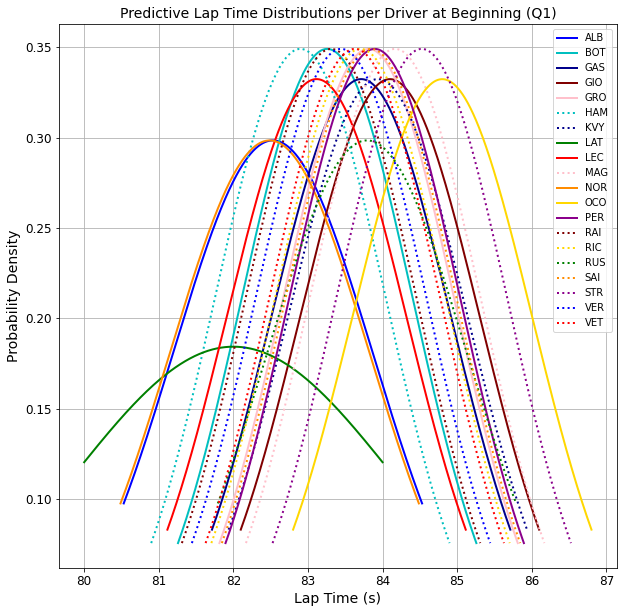

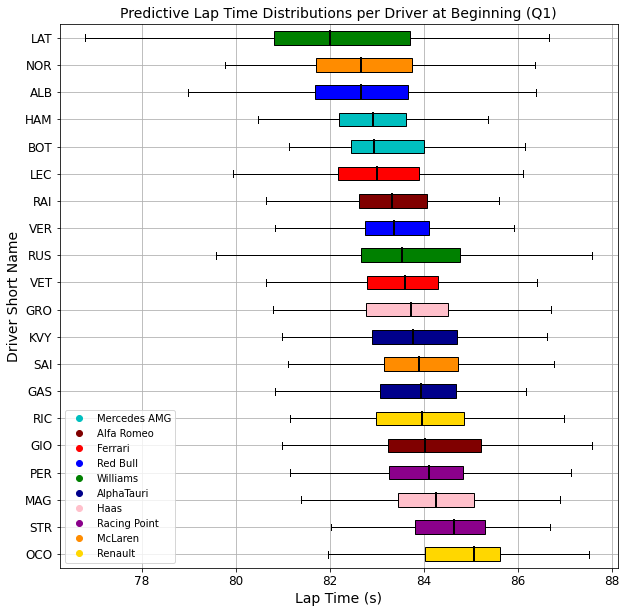

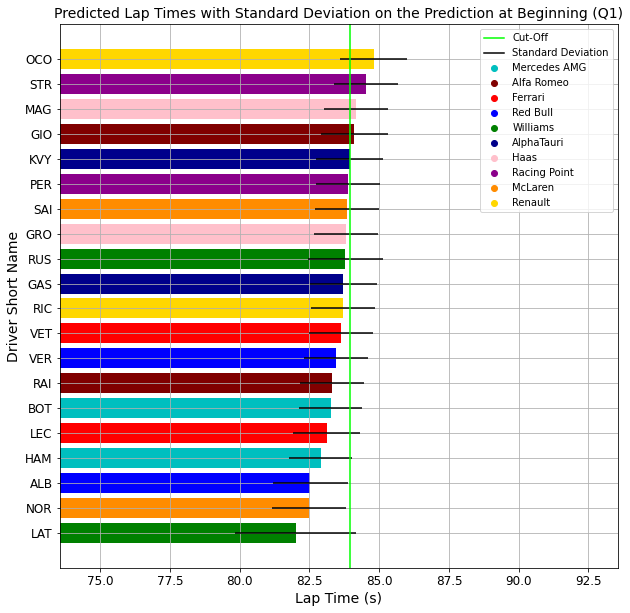

,ALB,BOT,GAS,GIO,GRO,HAM,KVY,LAT,LEC,MAG,NOR,OCO,PER,RAI,RIC,RUS,SAI,STR,VER,VET
Mean,82.530068,83.257772,83.713297,84.099275,83.813254,82.898348,83.936789,82.000000,83.115503,84.169119,82.486787,84.800945,83.894963,83.309866,83.704966,83.791509,83.845680,84.525839,83.443824,83.627895
SD,1.336865,1.142856,1.200312,1.200370,1.142856,1.142856,1.200370,2.165548,1.200312,1.142856,1.336865,1.200429,1.142856,1.142856,1.142856,1.336865,1.142856,1.142856,1.142856,1.142856


In [49]:
df = plots(predictions = current_predictions, standard_dev = current_predictions_sd, cutoff = current_predictions[i], names_list = names_2020, label = 'Beginning', stage = 'b', data = data_20_Q1)
display(df)

Q2 Results

In [23]:
print(f'Initial mean predictions from historical data are: {current_predictions}')
print(f'Initial standard deviation predictions from historical data are: {current_predictions_sd}')
print(f'Initial predicted cut-off is: {current_predictions[i]:.3f}')
print('')
print(f'Initial conservative predictions from historical data are: {current_predictions_conservative}')
print(f'Initial conservative predicted cut-off is: {current_predictions_conservative[j]:.3f}')

Initial mean predictions from historical data are: [82.21671393 82.03020238 81.         83.11717577 81.97489395 83.44062181
 81.51354204 82.04974    84.65568108 83.59430732 82.93406827 83.64607666
 83.50292117 82.54604898 82.26239603]
Initial standard deviation predictions from historical data are: [1.33573815 1.1426551  2.15044182 1.1426551  1.1426551  1.1999749
 1.33573815 1.33573815 1.20003283 1.1426551  1.1426551  1.20003283
 1.3359033  1.1426551  1.1426551 ]
Initial predicted cut-off is: 83.441

Initial conservative predictions from historical data are: [80.88097578413358, 80.88754727165667, 78.84955818493036, 81.97452067006486, 80.83223884146882, 82.24064691548601, 80.17780389346355, 80.71400185691765, 83.45564825288339, 82.45165221675876, 81.79141316569611, 82.44604383125362, 82.16701787631052, 81.40339387698764, 81.11974092994075]
Initial conservative predicted cut-off is: 82.167


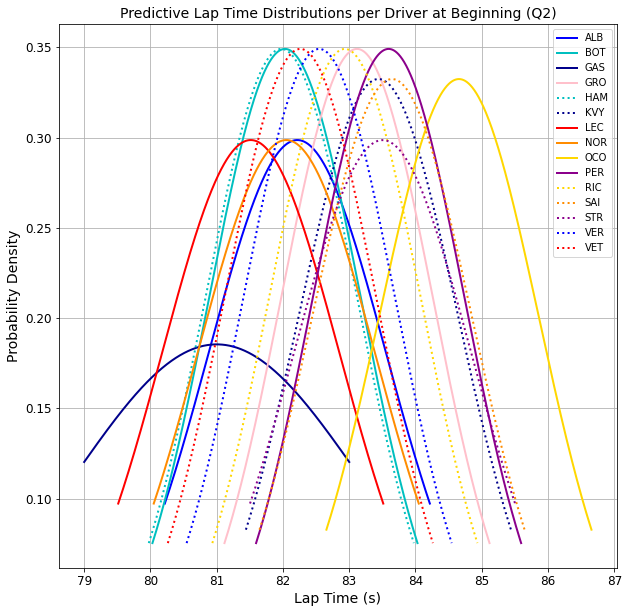

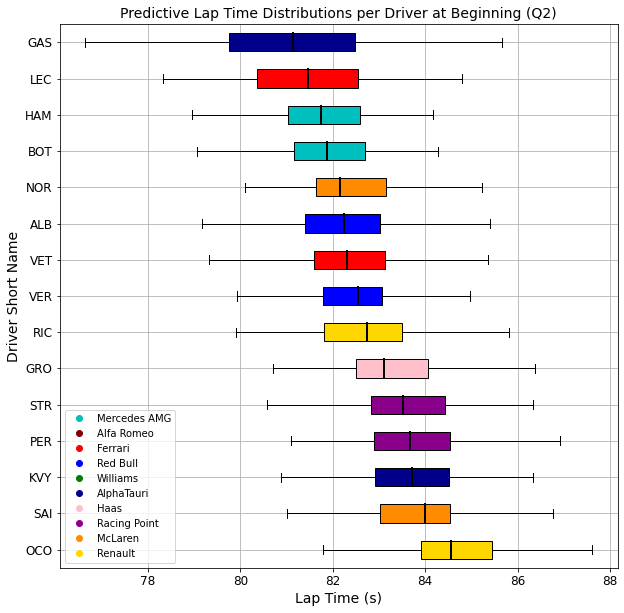

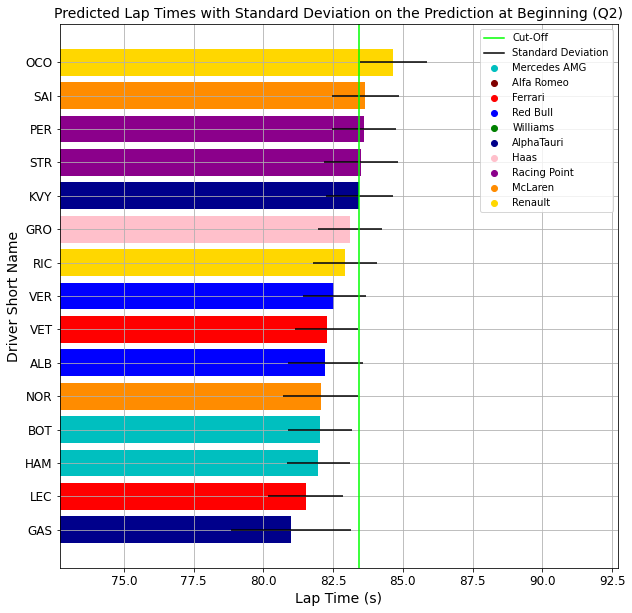

,ALB,BOT,GAS,GRO,HAM,KVY,LEC,NOR,OCO,PER,RIC,SAI,STR,VER,VET
Mean,82.216714,82.030202,81.000000,83.117176,81.974894,83.440622,81.513542,82.049740,84.655681,83.594307,82.934068,83.646077,83.502921,82.546049,82.262396
SD,1.335738,1.142655,2.150442,1.142655,1.142655,1.199975,1.335738,1.335738,1.200033,1.142655,1.142655,1.200033,1.335903,1.142655,1.142655


In [24]:
df = plots(predictions = current_predictions, standard_dev = current_predictions_sd, cutoff = current_predictions[i], names_list = names_2020, label = 'Beginning', stage = 'b', data = data_20_Q2)
display(df)